In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import date as mydate, datetime as mydatetime
import os
import pytz
import re
import time as mytime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging
import requests
import datetime
import warnings
warnings.filterwarnings('ignore')


In [ ]:
def exchange_positions(my_list, position1, position2):
    """
    Function to exchange item positions in a list.

    Used later in the project.
    """
    my_list[position1], my_list[position2] = my_list[position2], my_list[position1]


In [ ]:
def preprocess_data(data_list):
    """
    Modifies data for better consistency and removes unnecessary string data.

    Called later in the project.
    """
    prem_header = ">Premier League</h3>"
    epl_header = ">English Premier League</h3>"
    prem_span = "$0Premier League"
    epl_span = "$0English Premier League"

    for indx, item in enumerate(data_list):
        if prem_header in item:
            data_list[indx] = item.replace(prem_header, epl_header)
        elif prem_span in item:
            data_list[indx] = item.replace(prem_span, epl_span)

    leagues = ['English Premier League', 'Spanish La Liga', 'German Bundesliga', 'Italian Serie A',
               'French Ligue 1', 'Champions League']

    data_list = [i[-145:] for i in data_list]
    left, right = '">', '</'
    data_list = [[l[l.index(left)+len(left):l.index(right)] for l in data_list if i in l] for i in leagues]

    return data_list


In [ ]:
def organize_game_data(game_list):
    """
    Organizes game data with placeholders for home and away teams.

    Called later in the project.
    """
    for game in game_list:
        while '' in game:
            exchange_positions(game, game.index(''), game.index('') - 2)
            blank = game.index('')
            blank_2 = game.index('') + 2
            game[blank] = '(H)'
            game.insert(blank_2, '(A)')


In [ ]:
def prompt_user_for_date():
    """
    Prompts the user to enter a date in the format (YYYY-MM-DD).
    If the input is in the wrong format, the user is prompted to try again.

    Returns the selected date.
    """
    print_once = True
    while print_once:
        print(' ')
        date_to_look = input('Enter a date (YYYY-MM-DD) to view the matches in your selected leagues: ')

        match = re.match("[0-9]{4}-[0-9]{2}-[0-9]{2}", date_to_look)
        is_match = bool(match)

        if not is_match:
            os.system("clear")
            print("Invalid entry. Make sure your date is entered in ('YYYY-MM-DD') format: ")
            continue

        year, month, day = (int(x) for x in date_to_look.split('-'))
        selected_date = datetime.date(year, month, day)

        print(' ')
        print('-'*100)
        print('-'*100)
        print(' ')
        print('Matchups in the following leagues for {}, {} {}, {}:'.format(
            selected_date.strftime("%A"),
            selected_date.strftime("%B"),
            selected_date.strftime("%d"),
            selected_date.strftime("%Y")))
        print(' ')

        print_once = False

    return str(date_to_look)


In [ ]:
def perform_web_scraping(selected_date):
    """
    Web scraping code to fetch football scores and fixtures data for the selected date.

    Returns the cleaned and organized data.
    """
    url = "https://www.bbc.com/sport/football/scores-fixtures/" + selected_date

    html_content = requests.get(url).text

    soup = BeautifulSoup(html_content, "html.parser")

    tags = ["span", "h3"]
    classes = (["gs-u-display-none gs-u-display-block@m qa-full-team-name sp-c-fixture__team-name-trunc",
                "sp-c-fixture__status-wrapper qa-sp-fixture-status",
                'sp-c-fixture__number sp-c-fixture__number--time', "sp-c-fixture__number sp-c-fixture__number--home",
                "sp-c-fixture__number sp-c-fixture__number--home sp-c-fixture__number--ft",
                "sp-c-fixture__number sp-c-fixture__number--home sp-c-fixture__number--live-sport",
                "sp-c-fixture__number sp-c-fixture__number--away sp-c-fixture__number--live-sport",
                "sp-c-fixture__number sp-c-fixture__number--away sp-c-fixture__number--ft",
                'gel-minion sp-c-match-list-heading'])

    scraper = soup.find_all(tags, attrs={'class': classes})
    data = [str(item) for item in scraper]

    data = preprocess_data(data)  # Function call
    organize_game_data(data)      # Function call

    data = [item for item in data if len(item) != 0]

    return data


In [ ]:
def adjust_match_time():
    """
    Alters match time from UK time to the user's local time by detecting the user's timezone automatically.

    Returns the data with adjusted match times.
    """
    scraped_data = perform_web_scraping(selected_date)  # Function calls

    current_time = mytime.localtime()
    current_clock = mytime.strftime("%Y:%m:%d %H:%M:%S %Z %z", current_time)

    london_tz = pytz.timezone('Europe/London')
    datetime_london = mydatetime.now(london_tz)
    london_time = datetime_london.strftime("%Y:%m:%d %H:%M:%S %Z %z")

    current_hour, current_min = current_clock[-5:-2], current_clock[14:16]
    london_hour, london_min = london_time[-5:-2], london_time[14:16]

    # Comparing time difference between London and user's local time
    hour_diff = int(london_hour) - int(current_hour)
    min_diff = int(london_min) - int(current_min)

    if min_diff == 0:
        min_diff = str(min_diff) + '0'

    for group in scraped_data:
        for indx, item in enumerate(group):
            if ":" in item:
                if min_diff == '00':  # If there is no minute difference, change hours and keep minutes the same
                    new_time = str(int(item[:item.index(":")]) - hour_diff) + item[item.index(":"):]

                if min_diff != '00':  # If there is a minutes difference, change hours and minutes
                    new_time = str(int(item[:item.index(":")]) - hour_diff) + ":" + str(abs(min_diff) + int(item[item.index(":") + 1:]))

                if int(new_time[new_time.index(":") + 1:]) >= 60:
                    # If the new 'minutes' value is >= 60, adjust the hours and minutes accordingly
                    new_time = str(int(new_time[:new_time.index(":")]) + 1) + ":" + str(int(new_time[new_time.index(":") + 1:]) - 60)

                if int(new_time[:new_time.index(":")]) >= 24:
                    # If the new hours value is >= 24, adjust the hours and add a '+1' to signify the game is the next day
                    new_time = "0" + str(int(item[:item.index(":")]) - 24) + ":" + str(int(item[item.index(":") + 1:])) + " +1"

                if new_time[new_time.index(":") + 1:] == '0':
                    new_time = new_time + '0'  # Add a second '0' to minutes value if there is only one

                try:
                    # If minutes value is between 1-9, add a '0' so that it reads '11:07' rather than '11:7'
                    if 0 < int(new_time[new_time.index(":") + 1:]) < 10:
                        colon = new_time.find(":")
                        new_time = new_time[:colon + 1] + '0' + new_time[colon + 1:]
                except ValueError:
                    group[indx] = new_time
                    continue
                group[indx] = new_time

    scraped_data = [[item.replace('&amp;', '&') for item in group] for group in scraped_data]  # Brighton & Hove Albion problem

    return scraped_data


In [ ]:
def display_final_scores():
    """
    Final print function.

    If the user presses Enter in the terminal, the scores will refresh without the user needing to enter
    the date to search again. This way, it can be called once during matchdays and work throughout the day.
    """
    refresh = ''

    while refresh == '':
        count = 0
        league_index = 0
        home_team, home_score, away_team, away_score, match_time = 1, 2, 3, 4, 5

        data = adjust_match_time()

        no_games = all(len(group) == 0 for group in data)
        if no_games:
            print('NO GAMES ON THIS DATE')
            break

        for group in data:
            print(group[0])
            print('-'*25)

            while count < len(data[league_index][1:]) // 5:
                print("{:<25} {:^5} {:<25} {:^3} | {:>7}".format(
                    group[home_team], group[home_score], group[away_team], group[away_score], group[match_time]))
                count += 1
                home_team += 5
                home_score += 5
                away_team += 5
                away_score += 5
                match_time += 5

            print(' ')
            league_index += 1
            count, home_team, home_score, away_team, away_score, match_time = 0, 1, 2, 3, 4, 5

        refresh = input('Press "Enter" to refresh the page: ')
        os.system("clear")


In [ ]:
if __name__ == "__main__":
    selected_date = prompt_user_for_date()
    display_final_scores()


 
Enter a date (YYYY-MM-DD) to view the matches in your selected leagues: 2023-12-02
 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
 
Matchups in the following leagues for Saturday, December 02, 2023:
 
English Premier League
-------------------------
Arsenal                     2   Wolverhampton Wanderers    1  |      FT
Brentford                   3   Luton Town                 1  |      FT
Burnley                     5   Sheffield United           0  |      FT
Nottingham Forest           0   Everton                    1  |      FT
Newcastle United            1   Manchester United          0  |      FT
 
Spanish La Liga
-------------------------
Girona                      2   Valencia                   1  |      FT
Athletic Bilbao             4   Rayo Vallecano             0  |      FT
Real Madrid                 2   Granada    

In [ ]:
def scrape_bbc_sport_pl_top_scorers(url):
    """
    Scrapes the top scorers' statistics from the given BBC Sport Premier League page.

    Args:
    - url (str): The URL of the BBC Sport page.

    Returns:
    - pd.DataFrame: A DataFrame containing the top scorers' statistics.
    """
    try:
        # Send an HTTP request to the URL
        response = requests.get(url)
        response.raise_for_status()  # Raises an HTTPError for bad responses

        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the table containing the top scorers' statistics
        table = soup.find('table', {'class': 'gs-o-table'})

        # Extract data from the table
        data = []
        for row in table.find_all('tr')[0:]:  # Skip the header row
            columns = row.find_all(['td', 'th'])
            data.append([column.get_text(strip=True) for column in columns])
        # print(data)
        # Create a DataFrame from the extracted data
        columns = data[0]
        column_names = ['Index', 'Player Name', 'Goals', 'Assists', 'Played', 'Goalsx90', 'MinsPerGoal', 'TotalShots', 'Conversion', 'Accuracy']
        df = pd.DataFrame(data[1:], columns=columns)
        df.columns = column_names

        # Split the "Player Name" column into "Player" and "Team" columns
        df[['Player', 'Team']] = df['Player Name'].str.extract(r'^(.*?)([A-Z].*)$')
        return df[['Player', 'Team', 'Goals', 'Assists', 'Played', 'Goalsx90', 'MinsPerGoal', 'TotalShots', 'Conversion', 'Accuracy']]

    except requests.RequestException as e:
        logging.error(f"Failed to retrieve the webpage. Error: {e}")
        return pd.DataFrame()

if __name__ == "__main__":
    bbc_sport_pl_url = "https://www.bbc.com/sport/football/premier-league/top-scorers"
    pl_top_scorers_data = scrape_bbc_sport_pl_top_scorers(bbc_sport_pl_url)

    # Display the DataFrame
    print(pl_top_scorers_data)


   Player                                               Team Goals Assists  \
0               Erling HaalandHaalandManchester CityMan City    14       4   
1                       Mohamed SalahSalahLiverpoolLiverpool    10       6   
2          Son Heung-minSon Heung-minTottenham HotspurTot...     9       2   
3                 Ollie WatkinsWatkinsAston VillaAston Villa     8       6   
4                   Jarrod BowenBowenWest Ham UnitedWest Ham     8       1   
5          Hwang Hee-chanHwang Hee-chanWolverhampton Wand...     7       2   
6           Dominic SolankeSolankeAFC BournemouthBournemouth     7       1   
7               Callum WilsonWilsonNewcastle UnitedNewcastle     7       0   
8                Alexander IsakIsakNewcastle UnitedNewcastle     7       0   
9              Anthony GordonGordonNewcastle UnitedNewcastle     6       3   
10                      Bryan MbeumoMbeumoBrentfordBrentford     6       3   
11                      Nicolas JacksonJacksonChelseaChelsea    

Visualizations & Analysis:
    

In [ ]:
pip install matplotlib seaborn


In [ ]:
# Convert numerical columns to appropriate data types
pl_top_scorers_data['Goals'] = pd.to_numeric(pl_top_scorers_data['Goals'])
pl_top_scorers_data['Assists'] = pd.to_numeric(pl_top_scorers_data['Assists'])
pl_top_scorers_data['Played'] = pd.to_numeric(pl_top_scorers_data['Played'])
pl_top_scorers_data['Goalsx90'] = pd.to_numeric(pl_top_scorers_data['Goalsx90'])
pl_top_scorers_data['MinsPerGoal'] = pd.to_numeric(pl_top_scorers_data['MinsPerGoal'].replace('-', '0'))  # Handling '-' values
pl_top_scorers_data['TotalShots'] = pd.to_numeric(pl_top_scorers_data['TotalShots'])

In [ ]:
# Check if 'Conversion' and 'Accuracy' columns are already numeric
if pl_top_scorers_data['Conversion'].dtype == 'object':
    pl_top_scorers_data['Conversion'] = pl_top_scorers_data['Conversion'].str.rstrip('%').astype(float)

if pl_top_scorers_data['Accuracy'].dtype == 'object':
    pl_top_scorers_data['Accuracy'] = pl_top_scorers_data['Accuracy'].str.rstrip('%').astype(float)


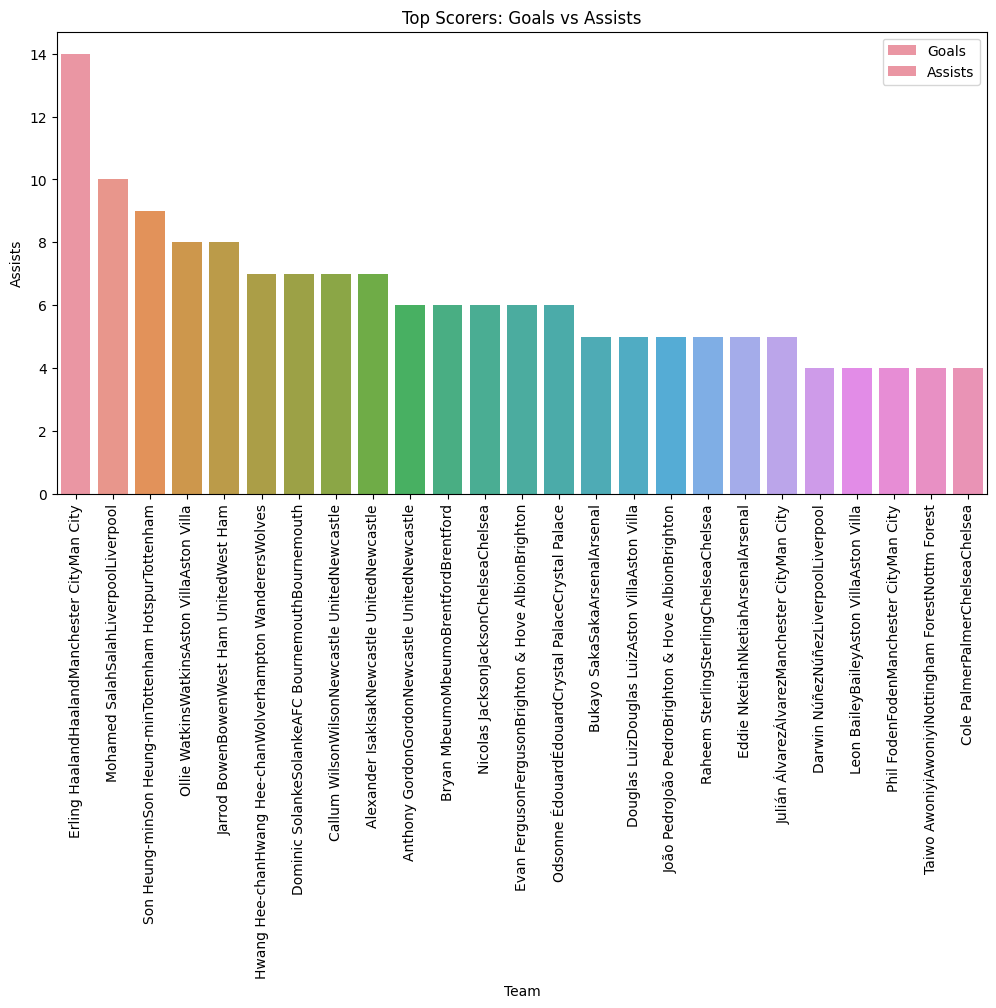

In [ ]:
# Visualization 1: Goals and Assists comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='Goals', data=pl_top_scorers_data, label='Goals')
sns.barplot(x='Team', y='Assists', data=pl_top_scorers_data, label='Assists')
plt.title('Top Scorers: Goals vs Assists')
plt.xticks(rotation=90)
plt.legend()
plt.show()

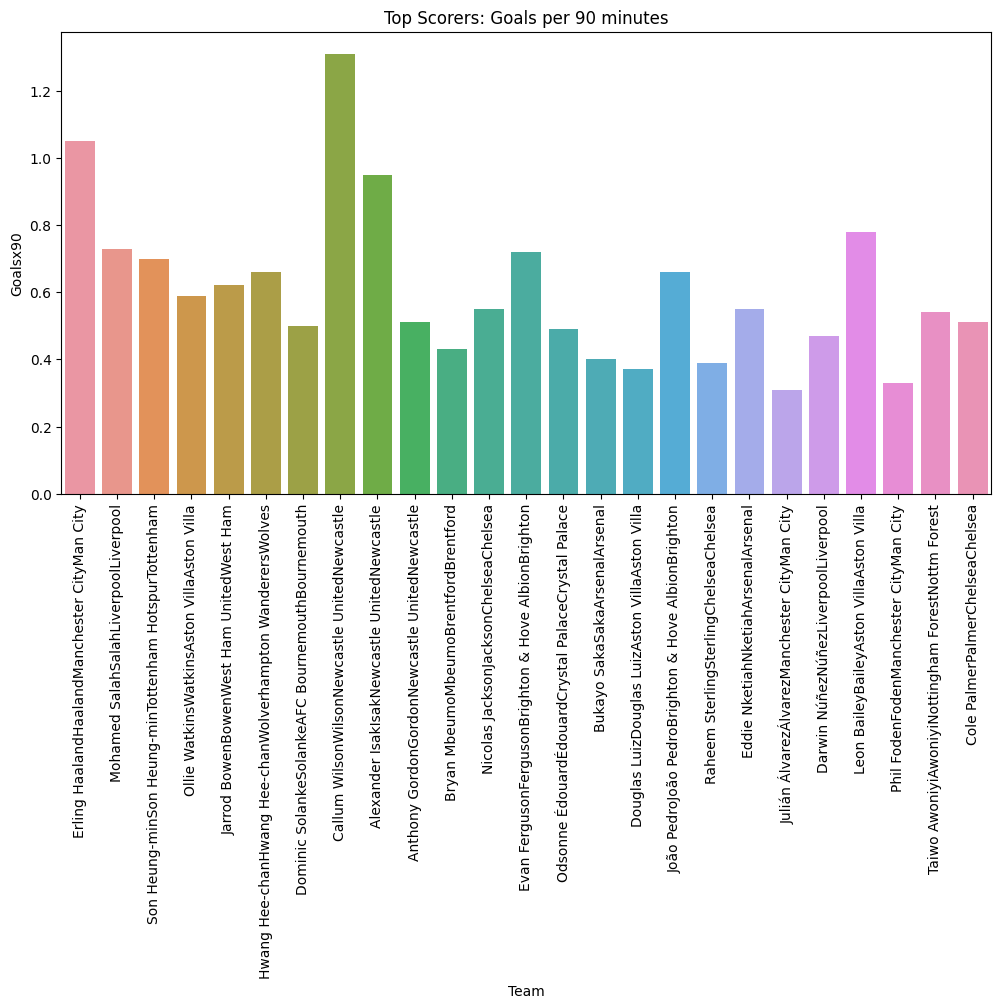

In [ ]:
# Visualization 2: Goals per 90 minutes
plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='Goalsx90', data=pl_top_scorers_data)
plt.title('Top Scorers: Goals per 90 minutes')
plt.xticks(rotation=90)
plt.show()

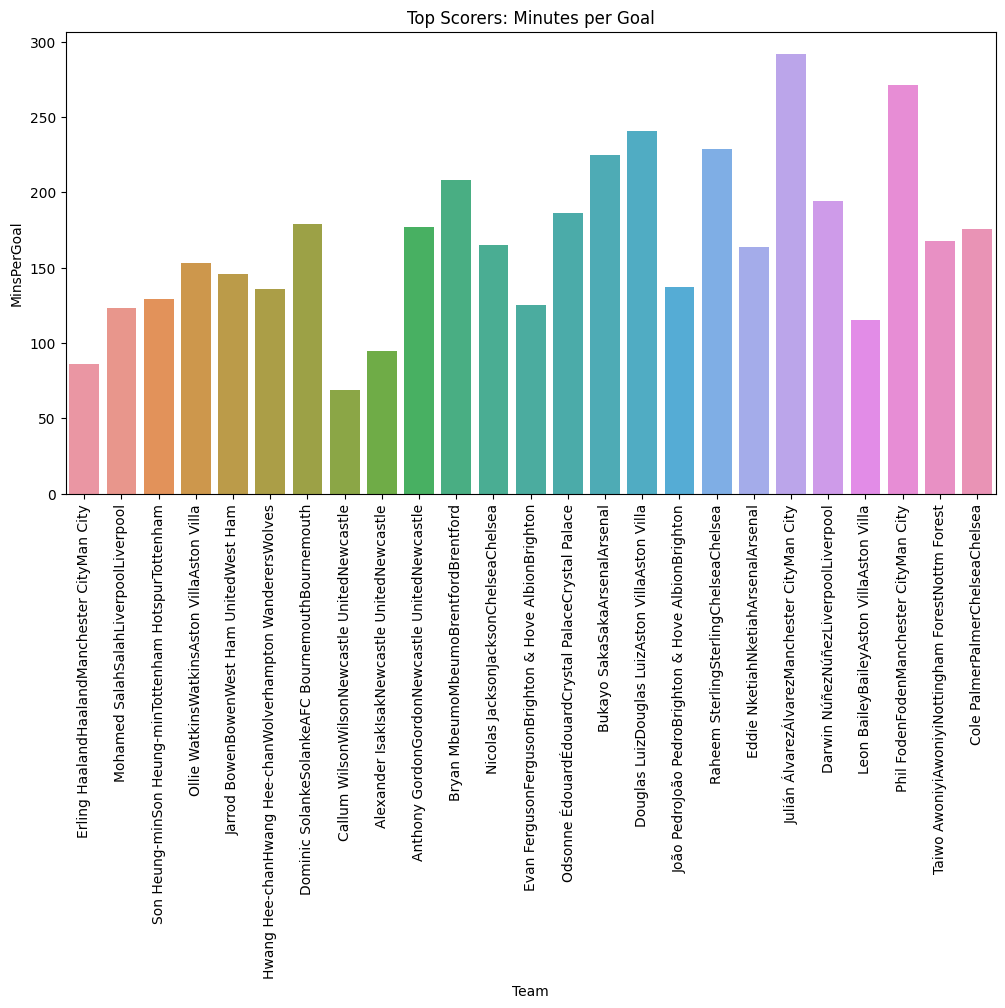

In [ ]:
# Visualization 3: Minutes per Goal
plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='MinsPerGoal', data=pl_top_scorers_data)
plt.title('Top Scorers: Minutes per Goal')
plt.xticks(rotation=90)
plt.show()

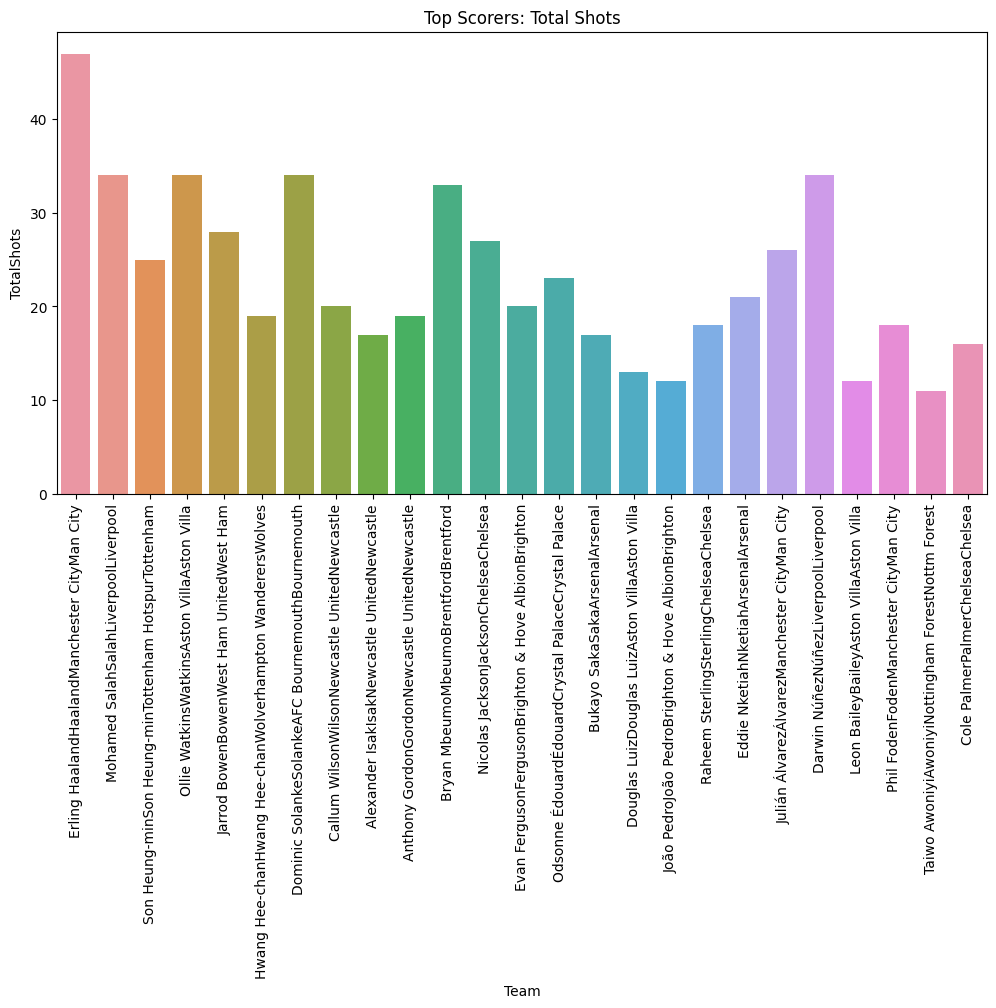

In [ ]:

# Visualization 4: Total Shots
plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='TotalShots', data=pl_top_scorers_data)
plt.title('Top Scorers: Total Shots')
plt.xticks(rotation=90)
plt.show()

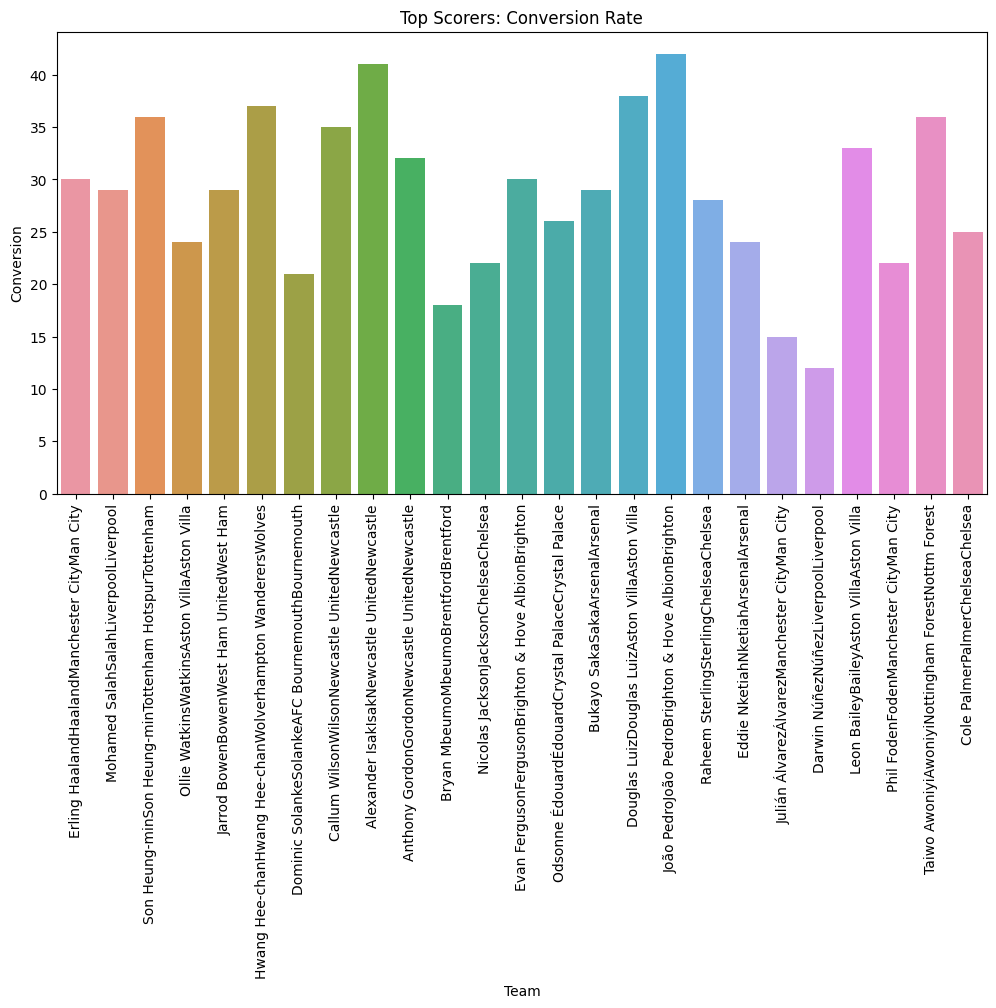

In [ ]:

# Visualization 5: Conversion Rate
plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='Conversion', data=pl_top_scorers_data)
plt.title('Top Scorers: Conversion Rate')
plt.xticks(rotation=90)
plt.show()

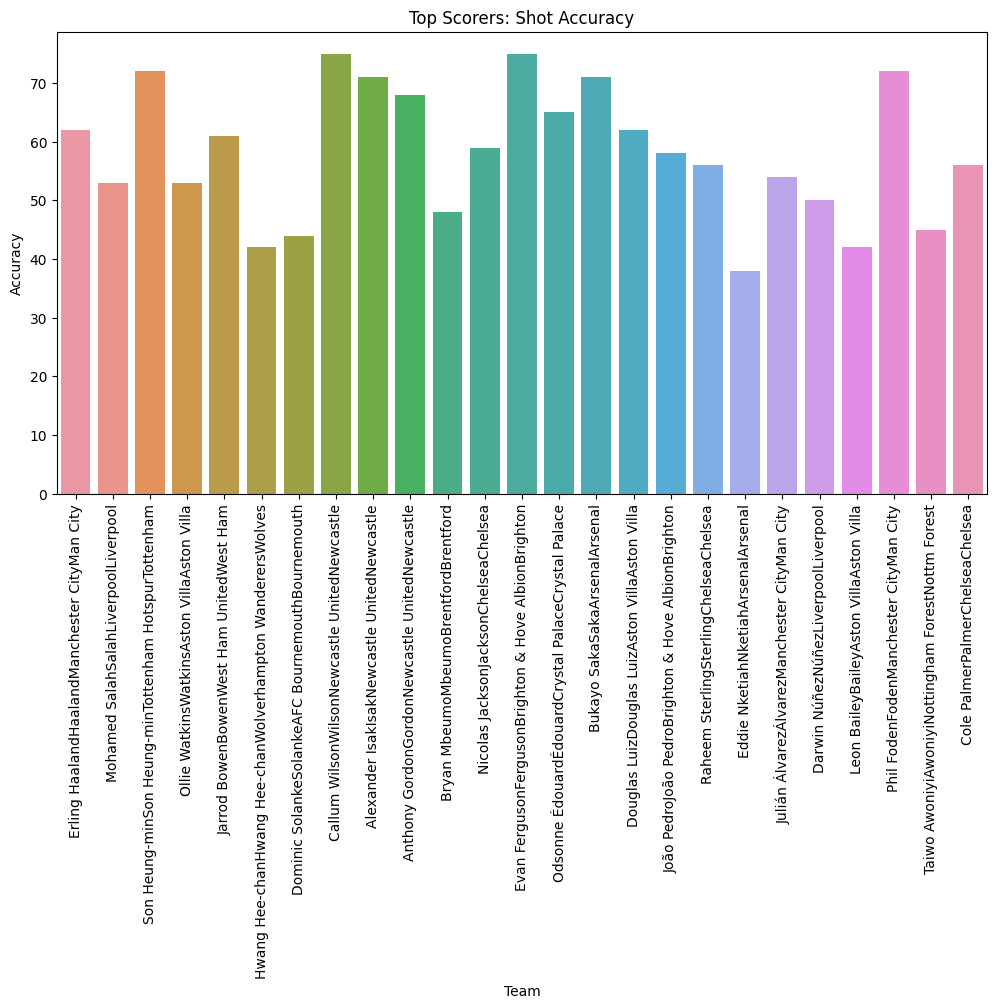

In [ ]:
# Visualization 6: Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='Accuracy', data=pl_top_scorers_data)
plt.title('Top Scorers: Shot Accuracy')
plt.xticks(rotation=90)
plt.show()
